<a href="https://colab.research.google.com/github/hamedebrahimi68/deep_learning_models/blob/main/man_women_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###imports

In [1]:
import os
import shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, Model, Sequential, optimizers, Input
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

###load data


In [2]:
from google.colab import files
_=files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
 98% 792M/806M [00:06<00:00, 161MB/s]
100% 806M/806M [00:06<00:00, 132MB/s]


In [6]:
!unzip -qq menwomen-classification.zip

###data preparation

In [8]:
len(os.listdir("traindata/traindata/women"))

1912

####train/test/validation

In [9]:
new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
            os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(base_dir, category, fname),
            dst=os.path.join(dir, fname))

In [10]:
make_subset("traindata/traindata", "validation", start_index=0, end_index=200)
make_subset("traindata/traindata", "train", start_index=200, end_index=1000)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

In [11]:
print('Train loader:')
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)
print('Validation loader:')
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)
print('Test loader:')
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary')

Train loader:
Found 1600 files belonging to 2 classes.
Validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


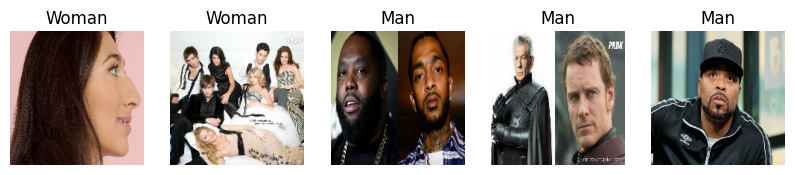

In [12]:
for data_batch, label_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('label batch shape:', label_batch.shape)

    # Show five random examples of the loaded batch
    fig, axes = plt.subplots(1, 5, figsize=(10,3))
    for i, ax in enumerate(axes):
        ax.imshow(data_batch[i].numpy().astype('uint8'))
        ax.set_axis_off()
        ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
    break

plt.show()

###model design

####load pretrained model

In [13]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

####costum model design

In [24]:
for layer in conv_base.layers:
        layer.trainable = False

In [30]:
inp = Input(shape=(180,180,3))
x = conv_base(inp)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=out)

In [31]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                           

###model fit

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data = validation_dataset)

Epoch 1/30
50/50 [==============================] - 27s 484ms/step - loss: 1.5962 - accuracy: 0.6981 - val_loss: 0.7642 - val_accuracy: 0.7475
Epoch 2/30
50/50 [==============================] - 25s 475ms/step - loss: 0.6591 - accuracy: 0.7750 - val_loss: 0.4247 - val_accuracy: 0.8125
Epoch 3/30
50/50 [==============================] - 25s 480ms/step - loss: 0.4621 - accuracy: 0.8150 - val_loss: 0.3707 - val_accuracy: 0.8450
Epoch 4/30
50/50 [==============================] - 25s 479ms/step - loss: 0.4029 - accuracy: 0.8381 - val_loss: 0.3676 - val_accuracy: 0.8575
Epoch 5/30
50/50 [==============================] - 25s 476ms/step - loss: 0.3342 - accuracy: 0.8569 - val_loss: 0.3861 - val_accuracy: 0.8400
Epoch 6/30
50/50 [==============================] - 25s 474ms/step - loss: 0.3367 - accuracy: 0.8581 - val_loss: 0.3919 - val_accuracy: 0.8300
Epoch 7/30
50/50 [==============================] - 25s 480ms/step - loss: 0.3165 - accuracy: 0.8756 - val_loss: 0.3488 - val_accuracy: 0.8725